In [12]:
%reload_ext autoreload
%autoreload 2

import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import pandas as pd

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'conductivity_effect')
sys.path.append(PARENT_DIR)

import materials.presets as sampling
import linearization.surface as surface
from materials.presets import SampleMaterial
from parametric_solver.solver import BilinearThermalSolver, BilinearThermalSample, NodeContext

In [13]:
OUT_DIR = os.path.join(CURR_DIR, 'out', 'temp_interp', 'kdoped_rhenium')
KDOPED_RHENIUM_DIR = os.path.join(CURR_DIR, 'in', 'temp_interp', 'kdoped_rhenium')
INP_DIR = os.path.join(KDOPED_RHENIUM_DIR, 'inp')
MATPOINT_DIR = os.path.join(KDOPED_RHENIUM_DIR, 'matpoint')

CASES = ['low', 'nominal', 'high']
COMPS = ['jet_matpoint.out', 'thimble_matpoint.out']
SAMPLE_N = 9

In [14]:
solver = BilinearThermalSolver(write_path=OUT_DIR, loglevel="INFO", nproc=8)

for i in range(1, SAMPLE_N + 1):
    sample = BilinearThermalSample()
    sample.name = f"kdoped_rhenium_{i}"
    sample.input = os.path.join(INP_DIR, f"{sample.name}.inp")
    sampling.set_structural(sample, SampleMaterial.W_3RHENIUM, True)
    solver.add_sample(sample)

# Solve at all sample points
solver.solve(verbose=False)

Solving [1/9]		Time Remaining: Unknown
Sample: kdoped_rhenium_1
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\temp_interp\kdoped_rhenium\kdoped_rhenium_1.pkl ...
Solving [2/9]		Time Remaining:  0h:00m:08s
Sample: kdoped_rhenium_2
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\temp_interp\kdoped_rhenium\kdoped_rhenium_2.pkl ...
Solving [3/9]		Time Remaining:  0h:00m:07s
Sample: kdoped_rhenium_3
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\temp_interp\kdoped_rhenium\kdoped_rhenium_3.pkl ...
Solving [4/9]		Time Remaining:  0h:00m:06s
Sample: kdoped_rhenium_4
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\temp_interp\kdoped_rhenium\kdoped_rhenium_4.pkl ...
Solving [5/9]		Time Remaining:  0h:00m:05s
Sample: kdoped_rhenium_5
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\temp_interp\kdoped_rhenium\kdoped_rhenium_5.pkl ...
Solving [6/9]		Time

In [27]:
def sample_name(_i):
    return f"kdoped_rhenium_{_i}"

def get_result(_i):
    return solver.result_from_name(f"kdoped_rhenium_{_i}")


def get_df(_path):
    _df = pd.read_csv(_path, index_col=0)
    _df.columns = _df.columns.str.strip()
    return _df


def mean_temp(_path):
    _df = get_df(_path)
    return _df['temperature'].mean()


def max_eqv_stresses():
    _max_stresses = []
    for _i in range(1, SAMPLE_N):
        _result = get_result(_i)
        
        if not _nodes:
            _nodes = _result.valid_nodes()

        _max_stresses.append(max([_result.eqv_stress(node) for node in _nodes]))

    return _max_stresses


def mean_temps():
    _avg_temps = []
    _avg_temps.append(mean_temp(os.path.join(MATPOINT_DIR, 'thimble_matpoint_low.out')))
    
    midpoints = int((SAMPLE_N - 3) / 2 + 1)
    for _i in range(1, midpoints):
        _path = os.path.join(MATPOINT_DIR, f'thimble_matpoint_low_{_i}.out')
        _avg_temps.append(mean_temp(_path))
        
    _avg_temps.append(mean_temp(os.path.join(MATPOINT_DIR, 'thimble_matpoint_nominal.out')))
    
    for _i in range(1, midpoints):
        _path = os.path.join(MATPOINT_DIR, f'thimble_matpoint_nominal_{_i}.out')
        _avg_temps.append(mean_temp(_path))
        
    _avg_temps.append(mean_temp(os.path.join(MATPOINT_DIR, 'thimble_matpoint_high.out')))
    
    return _avg_temps
        
    
def max_linearization(stress):
    NODES_DIR = os.path.join(PARENT_DIR, 'inp', 'nodes')
    TOP_SURFACE_PATH = os.path.join(NODES_DIR, 'ts.node.loc')
    BOTTOM_SURFACE_PATH = os.path.join(NODES_DIR, 'bs.node.loc')
    ALL_LOCS_PATH = os.path.join(NODES_DIR, 'all.node.loc')

    membrane_data = []
    bending_data = []
    linearized_data = []

    for _i in range(1, SAMPLE_N + 1):
        curr_name = sample_name(_i)
        curr_result = solver.result_from_name(curr_name)

        if stress:
            dataframe = curr_result.stress_dataframe()
        else:
            dataframe = curr_result.strain_dataframe()

        stress_result = surface.linearize_surface(
            TOP_SURFACE_PATH,
            BOTTOM_SURFACE_PATH,
            dataframe,
            ALL_LOCS_PATH,
            None
        )

        total_result = stress_result['membrane'] + stress_result['bending']

        membrane_data.append(max(stress_result['membrane']))
        bending_data.append(max(stress_result['bending']))
        linearized_data.append(max(total_result))
        
    return membrane_data, bending_data, linearized_data


def plot_vals(x, y, legend, title, xlabel, ylabel, ax=None):
    if ax is None:
        ax = plt.subplot()
        
    real_i = [0, int(SAMPLE_N / 2), -1]
    interp_i = [_i for _i in range(SAMPLE_N) if _i not in real_i]
    
    real_x = [x[_i] for _i in real_i]
    interp_x = [x[_i] for _i in interp_i]
    real_y = [y[_i] for _i in real_i]
    interp_y = [y[_i] for _i in interp_i]
    
    ax.plot(x, y, color='blue', label=legend)
    ax.scatter(real_x, real_y, color='red', label="Solved Temperature")
    ax.scatter(interp_x, interp_y, color='blue', label="Offset Temperature")
    ax.set_title(f"{title}")
    ax.set_xlabel(f"{xlabel}")
    ax.set_ylabel(f"{ylabel}")
    ax.legend()


In [23]:
temps = mean_temps()
membrane_stress, bending_stress, linearized_stress = max_linearization(True)
membrane_strain, bending_strain, linearized_strain = max_linearization(False)

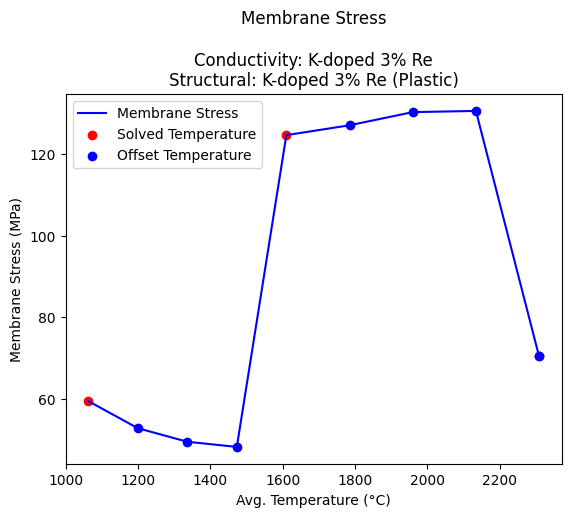

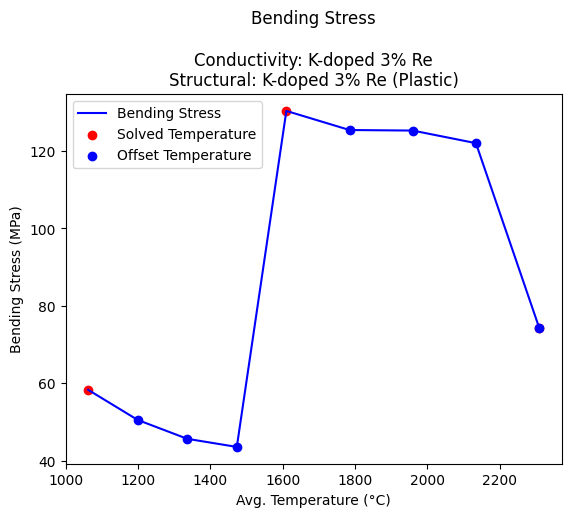

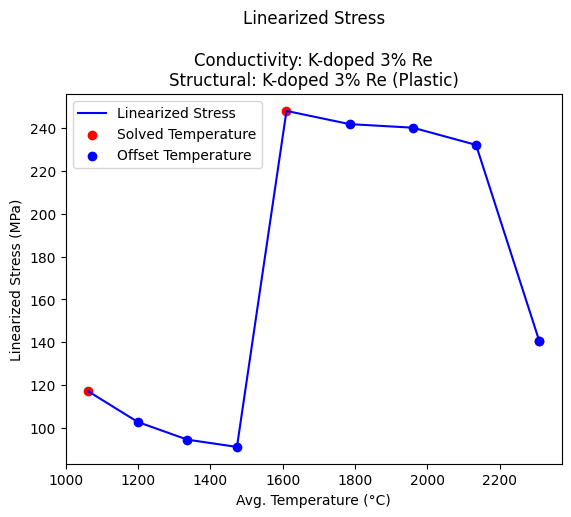

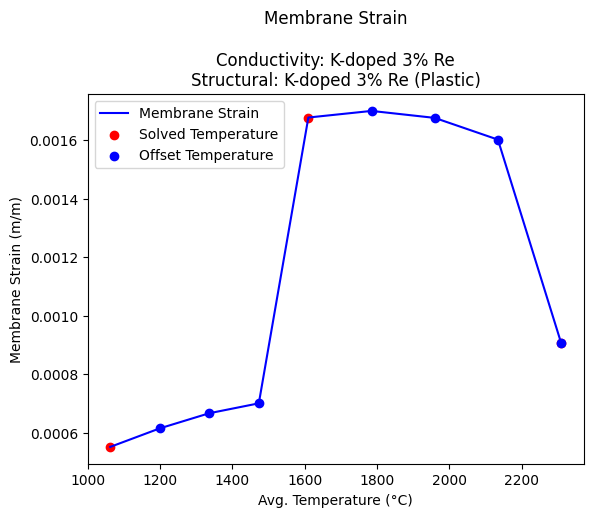

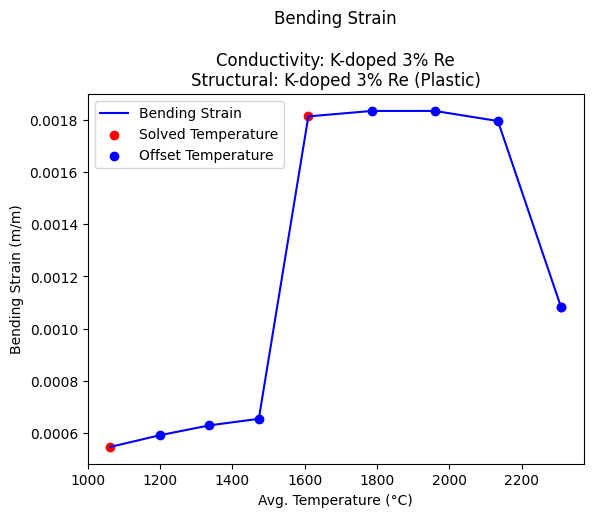

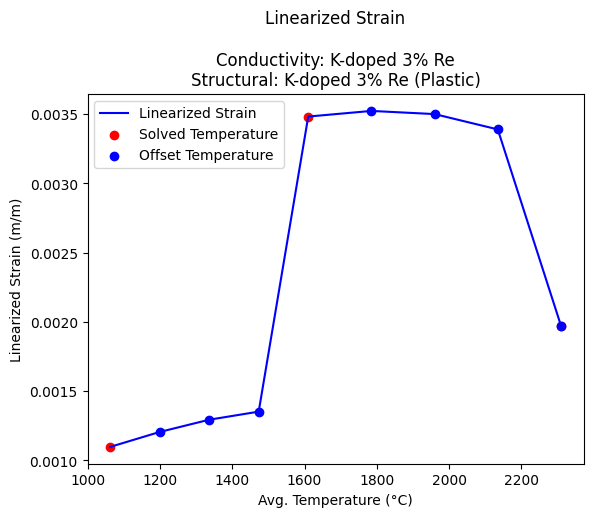

In [36]:
X_LABEL = "Avg. Temperature (°C)"

ax = plt.subplot()
plot_vals(temps, membrane_stress, "Membrane Stress", "Membrane Stress\n\nConductivity: K-doped 3% Re\nStructural: K-doped 3% Re (Plastic)", X_LABEL, "Membrane Stress (MPa)", ax=ax)
plt.show()

ax = plt.subplot()
plot_vals(temps, bending_stress, "Bending Stress", "Bending Stress\n\nConductivity: K-doped 3% Re\nStructural: K-doped 3% Re (Plastic)", X_LABEL, "Bending Stress (MPa)", ax=ax)
plt.show()

ax = plt.subplot()
plot_vals(temps, linearized_stress, "Linearized Stress", "Linearized Stress\n\nConductivity: K-doped 3% Re\nStructural: K-doped 3% Re (Plastic)", X_LABEL, "Linearized Stress (MPa)", ax=ax)
plt.show()

ax = plt.subplot()
plot_vals(temps, membrane_strain, "Membrane Strain", "Membrane Strain\n\nConductivity: K-doped 3% Re\nStructural: K-doped 3% Re (Plastic)", X_LABEL, "Membrane Strain (m/m)", ax=ax)
plt.show()

ax = plt.subplot()
plot_vals(temps, bending_strain, "Bending Strain", "Bending Strain\n\nConductivity: K-doped 3% Re\nStructural: K-doped 3% Re (Plastic)", X_LABEL, "Bending Strain (m/m)", ax=ax)
plt.show()

ax = plt.subplot()
plot_vals(temps, linearized_strain, "Linearized Strain", "Linearized Strain\n\nConductivity: K-doped 3% Re\nStructural: K-doped 3% Re (Plastic)", X_LABEL, "Linearized Strain (m/m)", ax=ax)
plt.show()